# ***A Classification Approach to Predict Hotel Booking Cancellation Using Classification Techniques and SMOTE***

---


### ***Dataset Description***

This data collection comprises reservation details for a city hotel and a resort hotel, such as the date the reservation was made, the duration of the stay, the number of people, kids, and/or babies, and the number of parking spaces available, among other details.

### ***Goal***
The goal of the study is to forecast hotel cancellations using machine learning and examine the most significant influencing factors.

### ***Objectives***
1. To analyze and understand the data by EDA
2. To conduct data preprocessing
3. To create segments for identifying the hidden insights by applying clustering model[customer segmentation]
4. To identify one suitable classification for predicting booking callenation
5. To predict the length of night stay using suitable regression model


---
The data analysis identified a number of problems that had a significant impact on the model's performance.

* The "reservation status" indicator for data leakage showed values that were identical to those of the target variable. To alleviate overfitting difficulties, this was taken into account during modeling.

* Identified Class imbalance in the feature "Hotel". 

---



## ***Import Libraries***

---



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import time
import datetime
import pickle
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

In [7]:
from plotly import express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import RFE # Recursive Feature Elimination
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix


## ***Read Data***

---



In [8]:
## Importing Data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hotel_bookings.csv')

## Show the first 5 rows of Data
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
data_imb = data.copy()

## ***Pre-Processing***

---



In [11]:
## Copy the dataset
data_cln= data.copy()

### ***Handling Missing Data***

---



In [12]:
#Missing Data
# Create new categories for both the agent and the company colum
data_cln['agent'] = pd.to_numeric(data_cln['agent'], errors='coerce')
data_cln['agent'] = data_cln['agent'].fillna(0).astype(int)

data_cln['company'] = pd.to_numeric(data_cln['company'], errors='coerce')
data_cln['company'] = data_cln['company'].fillna(0).astype(int)

# Changing children value of NULL to "0" and converting to integer type: 
data_cln['children'] = data_cln['children'].fillna(0).astype(int)
# Replacing null value for country feature with "unknown"
data_cln['country'] = data_cln['country'].fillna('Unknown')

In [13]:
# Checking that no missing values remain:
data_cln.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

### ***Feature Engineering/Data Transformation***

---



In [14]:
# Changing reservation status date to datetime type dur to discripency: 
data_cln['reservation_status_date'] = pd.to_datetime(data_cln['reservation_status_date'])

# Creating the arrival_data feature: 
data_cln['arrival_info'] = data_cln['arrival_date_year'].astype(str) + "-" + data_cln['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + data_cln['arrival_date_day_of_month'].astype(str)
data_cln['arrival_info'] = pd.to_datetime(data_cln['arrival_info'], format="%Y-%m-%d")

# Creating a new feature representing length of stay or how many days before arrival did the customer cancel:
data_cln['status_minus_arrival_date'] = np.abs(data_cln['arrival_info'] - data_cln['reservation_status_date']).astype(str)
# formating the feature 
def format_lenght(date):
    return date[0]
data_cln['status_minus_arrival_date'] = data_cln['status_minus_arrival_date'].map(format_lenght).astype(int)

#Create a new feature 'total_guests" by  merging adults,children and babies features
data_cln["total_guests"] = data_cln["adults"] + data_cln["children"] + data_cln["babies"]



In [15]:
data_cln.date = pd.to_datetime(data_cln.reservation_status_date)
# Create 3 new columns
data_cln[['year','month','day']] = data_cln.date.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))
data_cln.drop(['reservation_status_date','arrival_date_month'] , axis = 1, inplace = True)
data_cln.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,arrival_info,status_minus_arrival_date,total_guests,year,month,day
0,Resort Hotel,0,342,2015,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0,2,2015,07,01
1,Resort Hotel,0,737,2015,27,1,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0,0,0,Transient,0.0,0,0,Check-Out,2015-07-01,0,2,2015,07,01
2,Resort Hotel,0,7,2015,27,1,0,1,1,0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0,0,0,Transient,75.0,0,0,Check-Out,2015-07-01,1,1,2015,07,02
3,Resort Hotel,0,13,2015,27,1,0,1,1,0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,0,0,Transient,75.0,0,0,Check-Out,2015-07-01,1,1,2015,07,02
4,Resort Hotel,0,14,2015,27,1,0,2,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,0,Transient,98.0,0,1,Check-Out,2015-07-01,2,2,2015,07,03


In [16]:
data_cln['day'] = data_cln['day'].astype(int)
data_cln['month'] = data_cln['month'].astype(int)

In [17]:
data_cln.dtypes

hotel                                     object
is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                   int64
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type                        object
booking_changes     

### Data Handling

---
1. Categorical
2. Numerical

Best practice is to copy the orginal data before treating it

---



In [18]:
data_imp_feature = data_cln.copy()

In [19]:
#get the catergorical column's position to apply Kprototypes
cat_col = [data_cln.columns.get_loc(col) for col in list(data_cln.select_dtypes('object').columns)]

print('Cateforical Columns           : {}'.format(list(data_cln.select_dtypes('object').columns)))
print('Categorical Columns Position  : {}'.format(cat_col))

Cateforical Columns           : ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'year']
Categorical Columns Position  : [0, 11, 12, 13, 14, 18, 19, 21, 25, 29, 33]


In [20]:
data_imp_cat =data_imp_feature.copy()

### ***Encode Categorical Data***

---



In [21]:
# Importing LabelEncoder from Sklearn
# library from preprocessing Module.
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(data_imp_cat['hotel'])
label1 = le.fit_transform(data_imp_cat['meal'])
label2 = le.fit_transform(data_imp_cat['country'])
label3 = le.fit_transform(data_imp_cat['market_segment'])
label4 = le.fit_transform(data_imp_cat['distribution_channel'])
label5 = le.fit_transform(data_imp_cat['reserved_room_type'])
label6 = le.fit_transform(data_imp_cat['assigned_room_type'])
label7 = le.fit_transform(data_imp_cat['deposit_type'])
label8 = le.fit_transform(data_imp_cat['customer_type'])
label9 = le.fit_transform(data_imp_cat['reservation_status'])
label10 = le.fit_transform(data_imp_cat['year'])
 
# printing label
label
label1
label2
label3
label4
label5
label6
label7
label8
label9
label10

# removing the column 'Purchased' from df
# as it is of no use now.
data_imp_cat.drop('hotel',  axis=1, inplace=True)
data_imp_cat.drop('meal',  axis=1, inplace=True)
data_imp_cat.drop('country',  axis=1, inplace=True)
data_imp_cat.drop('market_segment',  axis=1, inplace=True)
data_imp_cat.drop('distribution_channel',  axis=1, inplace=True)
data_imp_cat.drop('reserved_room_type',  axis=1, inplace=True)
data_imp_cat.drop('assigned_room_type',  axis=1, inplace=True)
data_imp_cat.drop('deposit_type',  axis=1, inplace=True)
data_imp_cat.drop('customer_type',  axis=1, inplace=True)
data_imp_cat.drop('reservation_status',  axis=1, inplace=True)
data_imp_cat.drop('year',  axis=1, inplace=True)
 
# Appending the array to our dataFrame
# with column name 'Purchased'
#data_c['day'] = label
data_imp_cat['hotel'] = label
data_imp_cat['meal'] = label1
data_imp_cat['country'] = label2
data_imp_cat['market_segment'] =label3
data_imp_cat['distribution_channel'] =label4
data_imp_cat['reserved_room_type'] =label5
data_imp_cat['assigned_room_type'] = label6
data_imp_cat['deposit_type'] =label7
data_imp_cat['customer_type']=label8
data_imp_cat['reservation_status']=label9
data_imp_cat['year']=label10
 
# printing Dataframe
data_imp_cat

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_info,status_minus_arrival_date,total_guests,month,day,hotel,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,year
0,0,342,2015,27,1,0,0,2,0,0,0,0,0,3,0,0,0,0.00,0,0,2015-07-01,0,2,7,1,1,0,135,3,1,2,2,0,2,1,1
1,0,737,2015,27,1,0,0,2,0,0,0,0,0,4,0,0,0,0.00,0,0,2015-07-01,0,2,7,1,1,0,135,3,1,2,2,0,2,1,1
2,0,7,2015,27,1,0,1,1,0,0,0,0,0,0,0,0,0,75.00,0,0,2015-07-01,1,1,7,2,1,0,59,3,1,0,2,0,2,1,1
3,0,13,2015,27,1,0,1,1,0,0,0,0,0,0,304,0,0,75.00,0,0,2015-07-01,1,1,7,2,1,0,59,2,0,0,0,0,2,1,1
4,0,14,2015,27,1,0,2,2,0,0,0,0,0,0,240,0,0,98.00,0,1,2015-07-01,2,2,7,3,1,0,59,6,3,0,0,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,35,30,2,5,2,0,0,0,0,0,0,394,0,0,96.14,0,0,2017-08-30,7,2,9,6,0,0,15,5,3,0,0,0,2,1,3
119386,0,102,2017,35,31,2,5,3,0,0,0,0,0,0,9,0,0,225.43,0,2,2017-08-31,7,3,9,7,0,0,56,6,3,4,4,0,2,1,3
119387,0,34,2017,35,31,2,5,2,0,0,0,0,0,0,9,0,0,157.71,0,4,2017-08-31,7,2,9,7,0,0,43,6,3,3,3,0,2,1,3
119388,0,109,2017,35,31,2,5,2,0,0,0,0,0,0,89,0,0,104.40,0,0,2017-08-31,7,2,9,7,0,0,59,6,3,0,0,0,2,1,3


### ***Normalizing Numerical Data***

---



In [22]:
#Numerical Data
data_imp_num = data_imp_cat.copy()

In [23]:

# apply normalization techniques on Column 1
lead_time = 'lead_time'
data_imp_num[lead_time] = data_imp_num[lead_time] /data_imp_num[lead_time].abs().max()
arrival_date_week_number = 'arrival_date_week_number'
data_imp_num[arrival_date_week_number] = data_imp_num[arrival_date_week_number] /data_imp_num[arrival_date_week_number].abs().max()
arrival_date_day_of_month = 'arrival_date_day_of_month'
data_imp_num[arrival_date_day_of_month] = data_imp_num[arrival_date_day_of_month] /data_imp_num[arrival_date_day_of_month].abs().max()
stays_in_weekend_nights = 'stays_in_weekend_nights'
data_imp_num[stays_in_weekend_nights] = data_imp_num[stays_in_weekend_nights] /data_imp_num[stays_in_weekend_nights].abs().max()
stays_in_week_nights = 'stays_in_week_nights'
data_imp_num[stays_in_week_nights] = data_imp_num[stays_in_week_nights] /data_imp_num[stays_in_week_nights].abs().max()
adults = 'adults'
data_imp_num[adults] = data_imp_num[adults] /data_imp_num[adults].abs().max()
children = 'children'
data_imp_num[children] = data_imp_num[children] /data_imp_num[children].abs().max()
babies = 'babies'
data_imp_num[babies] =data_imp_num[babies] /data_imp_num[babies].abs().max()
is_repeated_guest = 'is_repeated_guest'
data_imp_num[is_repeated_guest] = data_imp_num[is_repeated_guest] /data_imp_num[is_repeated_guest].abs().max()
previous_cancellations = 'previous_cancellations'
data_imp_num[previous_cancellations] = data_imp_num[previous_cancellations] /data_imp_num[previous_cancellations].abs().max()
previous_bookings_not_canceled = 'previous_bookings_not_canceled'
data_imp_num[previous_bookings_not_canceled] = data_imp_num[previous_bookings_not_canceled] /data_imp_num[previous_bookings_not_canceled].abs().max()
agent = 'agent'
data_imp_num[agent] = data_imp_num[agent] /data_imp_num[agent].abs().max()
company = 'company'
data_imp_num[company] = data_imp_num[company] /data_imp_num[company].abs().max()
adr = 'adr'
data_imp_num[adr] = data_imp_num[adr] /data_imp_num[adr].abs().max()
arrival_date_year = 'arrival_date_year'
data_imp_num[arrival_date_year] = data_imp_num[arrival_date_year] /data_imp_num[arrival_date_year].abs().max()
required_car_parking_spaces = 'required_car_parking_spaces'
data_imp_num[required_car_parking_spaces] = data_imp_num[required_car_parking_spaces] /data_imp_num[required_car_parking_spaces].abs().max()
total_of_special_requests = 'total_of_special_requests'
data_imp_num[total_of_special_requests] = data_imp_num[total_of_special_requests] /data_imp_num[total_of_special_requests].abs().max()

status_minus_arrival_date = 'status_minus_arrival_date'
data_imp_num[status_minus_arrival_date] = data_imp_num[status_minus_arrival_date] /data_imp_num[status_minus_arrival_date].abs().max()
total_guests = 'total_guests'
data_imp_num[total_guests] = data_imp_num[total_guests] /data_imp_num[total_guests].abs().max()
month = 'month'
data_imp_num[month] = data_imp_num[month] /data_imp_num[month].abs().max()
day = 'day'
data_imp_num[day] = data_imp_num[day] /data_imp_num[day].abs().max()
# view normalized data
display(data_imp_num)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,arrival_info,status_minus_arrival_date,total_guests,month,day,hotel,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,year
0,0,0.464043,0.999008,0.509434,0.032258,0.000000,0.00,0.036364,0.0,0.0,0.0,0.0,0.0,3,0.000000,0.0,0,0.000000,0.0,0.0,2015-07-01,0.000000,0.036364,0.583333,0.032258,1,0,135,3,1,2,2,0,2,1,1
1,0,1.000000,0.999008,0.509434,0.032258,0.000000,0.00,0.036364,0.0,0.0,0.0,0.0,0.0,4,0.000000,0.0,0,0.000000,0.0,0.0,2015-07-01,0.000000,0.036364,0.583333,0.032258,1,0,135,3,1,2,2,0,2,1,1
2,0,0.009498,0.999008,0.509434,0.032258,0.000000,0.02,0.018182,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,0,0.013889,0.0,0.0,2015-07-01,0.111111,0.018182,0.583333,0.064516,1,0,59,3,1,0,2,0,2,1,1
3,0,0.017639,0.999008,0.509434,0.032258,0.000000,0.02,0.018182,0.0,0.0,0.0,0.0,0.0,0,0.568224,0.0,0,0.013889,0.0,0.0,2015-07-01,0.111111,0.018182,0.583333,0.064516,1,0,59,2,0,0,0,0,2,1,1
4,0,0.018996,0.999008,0.509434,0.032258,0.000000,0.04,0.036364,0.0,0.0,0.0,0.0,0.0,0,0.448598,0.0,0,0.018148,0.0,0.2,2015-07-01,0.222222,0.036364,0.583333,0.096774,1,0,59,6,3,0,0,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,0.031208,1.000000,0.660377,0.967742,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,0.0,0,0.736449,0.0,0,0.017804,0.0,0.0,2017-08-30,0.777778,0.036364,0.750000,0.193548,0,0,15,5,3,0,0,0,2,1,3
119386,0,0.138399,1.000000,0.660377,1.000000,0.105263,0.10,0.054545,0.0,0.0,0.0,0.0,0.0,0,0.016822,0.0,0,0.041746,0.0,0.4,2017-08-31,0.777778,0.054545,0.750000,0.225806,0,0,56,6,3,4,4,0,2,1,3
119387,0,0.046133,1.000000,0.660377,1.000000,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,0.0,0,0.016822,0.0,0,0.029206,0.0,0.8,2017-08-31,0.777778,0.036364,0.750000,0.225806,0,0,43,6,3,3,3,0,2,1,3
119388,0,0.147897,1.000000,0.660377,1.000000,0.105263,0.10,0.036364,0.0,0.0,0.0,0.0,0.0,0,0.166355,0.0,0,0.019333,0.0,0.0,2017-08-31,0.777778,0.036364,0.750000,0.225806,0,0,59,6,3,0,0,0,2,1,3


In [24]:
data_imp_num = data_imp_num.drop(['arrival_info'], axis=1)

### ***Identifying Important Feature using Correlation***

---



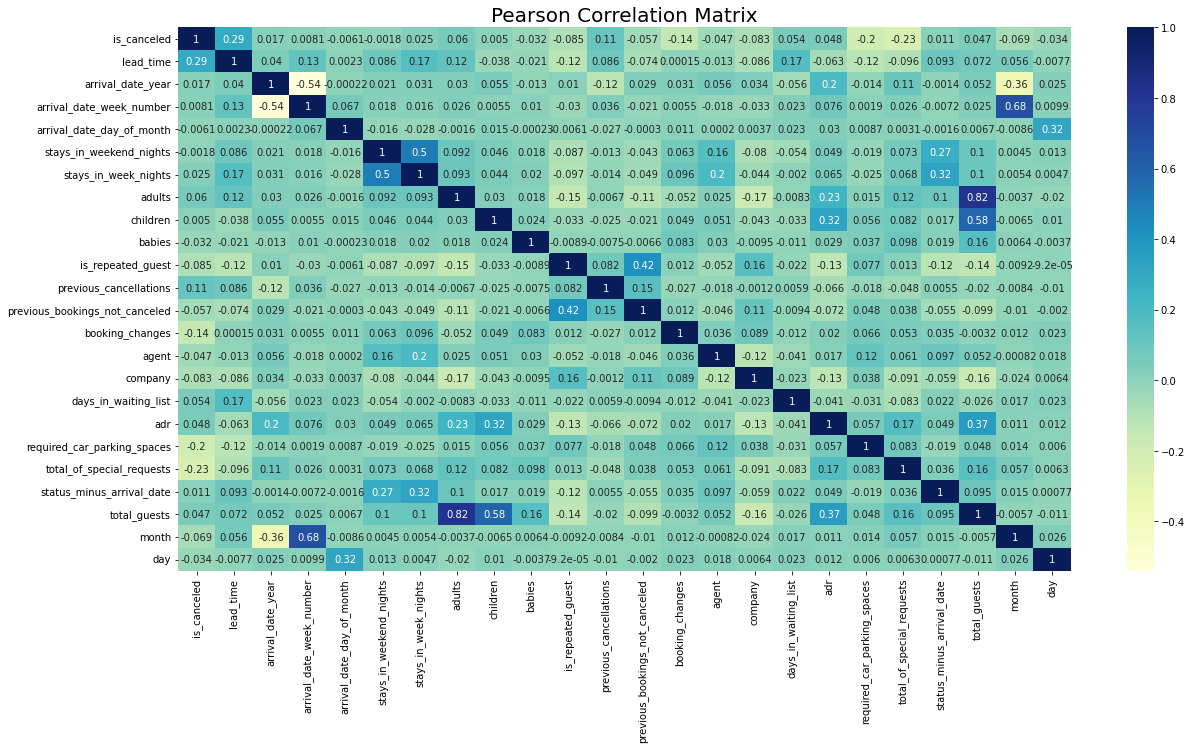

In [25]:
# Plot the correlation heatmap
corr = data_cln.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.title("Pearson Correlation Matrix", fontdict={'fontsize':20})
plt.show()

In [26]:
correlation = data_cln.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

is_canceled                       1.000000
lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
previous_cancellations            0.110133
is_repeated_guest                 0.084793
company                           0.082995
month                             0.068605
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
agent                             0.046529
total_guests                      0.046522
day                               0.034131
babies                            0.032491
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
status_minus_arrival_date         0.010512
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005036
stays_in_we

## Model Building

Now our data is ready to train the various classification model and test for predicting hotel booking cancellation

---



In [27]:
data_model = data_imp_num.copy()

### ***Target Value Selection***

---



In [28]:
#Select input and target Features
x = data_model.drop(['is_canceled'], axis=1)
y = data_model['is_canceled']

### ***Data Partition***

---



In [29]:
#Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20, shuffle=False)

### ***Fit the treated dataset with 9 Classification Models***

---



In [30]:

# Build Default Models
def build_models(x, y):

  print("IMPLEMENTATION STARTED(***Before Handling Unbalanced Data***)")
  print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

  # Store all the classifiers to built
  models = {'Logistic Regression' : LogisticRegression(),
            'KNN' :KNeighborsClassifier(),
            'Decision Tree' : DecisionTreeClassifier(),
            #'SVM' : SVC(), (by considering the response time temporarily keepimg in comment )
            'Random Forest' : RandomForestClassifier(),
            'Extra Trees' : ExtraTreesClassifier(),
            'AdaBoost' : AdaBoostClassifier(),
            'XGB' : XGBClassifier(),
            'LGBM' : LGBMClassifier()
            }

  # Store the trained models in a dictionary
  trained_models = {}

  # Note the start time
  function_start = datetime.datetime.now()
  print("Model Building begins at {}".format(function_start))

  start_time = time.time()
  # Iterate over models and model object
  for model, model_obj in models.items():

    # Note the starting time of the model
    model_start = time.time()
    print("{} Model begins".format(model))

    # Fit the model using cross_val_score
    cv_mean = np.mean(cross_val_score(model_obj, x, y, scoring='accuracy', cv=3, n_jobs=-1))

    # Store the cv score
    trained_models[model] = cv_mean
    
    # Note the end time and print the total time taken for the model to build
    model_end = time.time()
    print("{} Model built".format(model))
    print("Total time taken for {} model to build: {:.3f} seconds".format(model, model_end-model_start))
  
  results = pd.DataFrame(trained_models, index = ['Mean CV Accuracy']).T
  print("IMPLEMENTATION ENDS")
  print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
  print()
  end_time = time.time()
  print("Total time taken to build models: {:.3f} seconds".format(end_time-start_time))

  return results

In [31]:
model_results = build_models(x_train, y_train)

IMPLEMENTATION STARTED(***Before Handling Unbalanced Data***)
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Model Building begins at 2022-11-24 12:44:18.953920
Logistic Regression Model begins
Logistic Regression Model built
Total time taken for Logistic Regression model to build: 4.481 seconds
KNN Model begins
KNN Model built
Total time taken for KNN model to build: 91.466 seconds
Decision Tree Model begins
Decision Tree Model built
Total time taken for Decision Tree model to build: 1.269 seconds
Random Forest Model begins
Random Forest Model built
Total time taken for Random Forest model to build: 9.914 seconds
Extra Trees Model begins
Extra Trees Model built
Total time taken for Extra Trees model to build: 8.770 seconds
AdaBoost Model begins
AdaBoost Model built
Total time taken for AdaBoost model to build: 9.450 seconds
XGB Model begins
XGB Model built
Total time taken for XGB model to build: 14.696 seconds
LGBM Model begins
LGBM Model built
Total time

In [32]:
# Sort the results based on the accuracy
results_sorted_before_bal = model_results.sort_values('Mean CV Accuracy', ascending=False)

results_sorted_before_bal


,Mean CV Accuracy
Decision Tree,1.000000
AdaBoost,1.000000
XGB,1.000000
LGBM,1.000000
Random Forest,0.989782
Logistic Regression,0.957671
Extra Trees,0.887524
KNN,0.882173


**As most of the models accuracy is 100%, I have decided to handle unbalanced data and retrain the model with balanced data***

---



## ***Imbalance Data***

---



***Let me handle the unbalanced data and proceed with importamt features***

---



In [33]:
data_imp_num_bal = data_imp_num.copy()

In [34]:
data_imp_num_bal['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [35]:
!pip install imblearn 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from imblearn.over_sampling import SMOTE

In [37]:
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("Before OverSampling, Label count '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, Label count '0': {} \n".format(sum(y_train == 0)))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
sm = SMOTE(random_state = 2)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("After OverSampling, Label count '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, Label count '0': {}".format(sum(y_train_res == 0)))
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Before OverSampling, Label count '1': 44202
Before OverSampling, Label count '0': 51310 

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
After OverSampling, the shape of train_X: (102620, 34)
After OverSampling, the shape of train_y: (102620,) 

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
After OverSampling, Label count '1': 51310
After OverSampling, Label count '0': 51310
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [38]:
# Build Model after handling imbalanced data
def build_models(x, y):
  print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
  print("IMPLEMENTATION STARTED")
  print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

  # Store all the classifiers to built
  models = {'Logistic Regression' : LogisticRegression(),
            'KNN' :KNeighborsClassifier(),
            'Decision Tree' : DecisionTreeClassifier(),
            #'SVM' : SVC(),
            'Random Forest' : RandomForestClassifier(),
            'Extra Trees' : ExtraTreesClassifier(),
            'AdaBoost' : AdaBoostClassifier(),
            'XGB' : XGBClassifier(),
            'LGBM' : LGBMClassifier()
            }

  # Store the trained models in a dictionary
  trained_models = {}

  # Observe the progress initiated time
  function_start = datetime.datetime.now()
  print("Model Building initiated at {}".format(function_start))

  start_time = time.time()
  # Iterate over models and model object
  for model, model_obj in models.items():

    # Note the starting time of the model
    model_start = time.time()
    print("{} Model initiated".format(model))

    # Fit the model using cross_val_score
    cv_mean = np.mean(cross_val_score(model_obj, x, y, scoring='accuracy', cv=3, n_jobs=-1))

    # Store the cv score
    trained_models[model] = cv_mean
    
    # Note the end time and print the total time taken for the model to build
    model_end = time.time()
    print("{} Model built".format(model))
    print("Total time taken for {} model to build: {:.3f} seconds".format(model, model_end-model_start))
  
  results = pd.DataFrame(trained_models, index = ['Mean CV Accuracy']).T
  print("IMPLEMENTATION ENDS")
  print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
  print()
  end_time = time.time()
  print("Total amount of time taken to build models: {:.3f} seconds".format(end_time-start_time))

  return results

In [39]:
print("AFTER HANDLING UNBALANCED DATA")
model_results_after_bal = build_models(x_train_res, y_train_res)

AFTER HANDLING UNBALANCED DATA
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
IMPLEMENTATION STARTED
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Model Building initiated at 2022-11-24 12:47:33.309989
Logistic Regression Model initiated
Logistic Regression Model built
Total time taken for Logistic Regression model to build: 4.538 seconds
KNN Model initiated
KNN Model built
Total time taken for KNN model to build: 135.364 seconds
Decision Tree Model initiated
Decision Tree Model built
Total time taken for Decision Tree model to build: 1.324 seconds
Random Forest Model initiated
Random Forest Model built
Total time taken for Random Forest model to build: 16.524 seconds
Extra Trees Model initiated
Extra Trees Model built
Total time taken for Extra Trees model to build: 13.610 seconds
AdaBoost Model initiated
AdaBoost Model built
Total time taken for AdaBoost model to build: 14.785 seconds
XGB Model initiated
XGB M

In [40]:
# Sortong results based on the accuracy
results_sorted_after_bal = model_results_after_bal.sort_values('Mean CV Accuracy', ascending=False)
results_sorted_after_bal

,Mean CV Accuracy
AdaBoost,0.999873
Random Forest,0.999854
LGBM,0.999756
Decision Tree,0.999737
XGB,0.999717
Extra Trees,0.991162
Logistic Regression,0.977227
KNN,0.928981


***After balancing the data, accuracy has been reduced which showns no overfitting
Based on the above accuracy, it is clear that 'AdaBoostClassifier' is the best model 
Now, I am going to find the important feature before hypertuning the model***

---



## ***Feature Selection using Random Forest and RFE before building the model***

---



In [41]:
# Train an ensemble model and visualise the feature importance of each feature

# Random Forest Model
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train_res, y_train_res)

#Compute
test_acc_rf = rf_clf.score(x_test, y_test)

print("Accuracy of Random Forest Classifier Model on the test set is {}%".format(test_acc_rf*100))

Accuracy of Random Forest Classifier Model on the test set is 99.93718066839769%


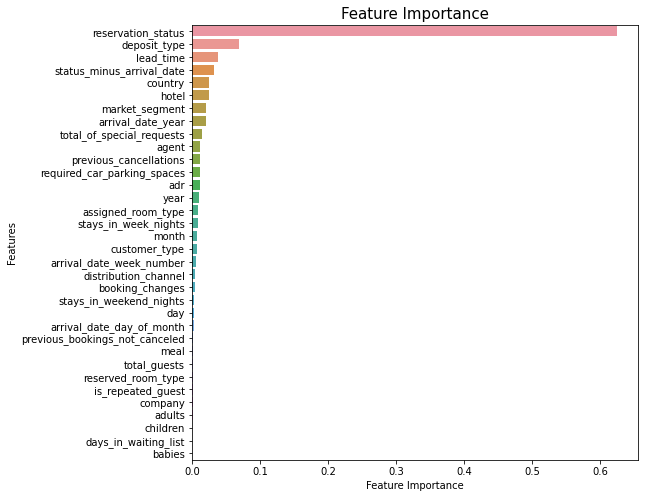

In [42]:
# Feature Importances
feature_importance = rf_clf.feature_importances_
features = x_train_res.columns
# Create a dictionary of features and the feature importances
feature_importance_dict = {features[i] : feature_importance[i] for i in range(len(feature_importance))}
feature_importance_df = pd.DataFrame(feature_importance_dict, index=['Feature Importance']).T.reset_index().rename(columns = {'index' : 'Features'})
feature_importance_df = feature_importance_df.sort_values('Feature Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8,8))
sns.barplot(x='Feature Importance', y='Features', data=feature_importance_df)
plt.title("Feature Importance", fontdict={'fontsize' : 15})
plt.show()

From the above plot it is clear that the feature "reservation_status_Check_Out" 
has the most importance.

---



In [43]:
data_cln['reservation_status'].value_counts()

Check-Out    75166
Canceled     43017
No-Show       1207
Name: reservation_status, dtype: int64

It was clear from the above analysis thet the :reservation_status column" has 3 categories which would assist in predicting the cancellation. To double check, I have decided to retrain the 'AdaBoostClassifier" model by dropping "reservation_status"

---



In [44]:
# Drop the reservation_status_Check_Out column
x_imp_f_without_reservation_status = x_train_res.drop("reservation_status", axis=1)

#Retrain the Model
print("-------------------------------------------------------------------------------------------")
print("AFTER removing 'Reservation_status'")
print("-------------------------------------------------------------------------------------------")
model_results_after_bal_without_res_status = build_models(x_imp_f_without_reservation_status, y_train_res)

-------------------------------------------------------------------------------------------
AFTER removing 'Reservation_status'
-------------------------------------------------------------------------------------------
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
IMPLEMENTATION STARTED
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Model Building initiated at 2022-11-24 12:51:14.559456
Logistic Regression Model initiated
Logistic Regression Model built
Total time taken for Logistic Regression model to build: 4.080 seconds
KNN Model initiated
KNN Model built
Total time taken for KNN model to build: 112.982 seconds
Decision Tree Model initiated
Decision Tree Model built
Total time taken for Decision Tree model to build: 1.627 seconds
Random Forest Model initiated
Random Forest Model built
Total time taken for Random Forest model to build: 23.124 seconds
Extra Trees Model initiated
Extra Trees Model built
Total t

In [45]:
# Sort the results in ascending order
print("-------------------------------------------------------------------------------------------")
print("ACCURACY AFTER REMOVING 'Reservation_status'")
print("-------------------------------------------------------------------------------------------")
results_sorted_without_res_status = model_results_after_bal_without_res_status.sort_values('Mean CV Accuracy', ascending=False)
results_sorted_without_res_status

-------------------------------------------------------------------------------------------
ACCURACY AFTER REMOVING 'Reservation_status'
-------------------------------------------------------------------------------------------


,Mean CV Accuracy
LGBM,0.847018
AdaBoost,0.714061
Random Forest,0.709384
XGB,0.708585
KNN,0.703187
Decision Tree,0.648996
Extra Trees,0.640187
Logistic Regression,0.628220


***As we can see, the above accuracy affected all the models and the model outstand among all comparitvely is LGBM and I am considering LGBM could also be considered as another suitable model among other classifier models***

---



## ***HyperTuning the Best Suitable  Model***

---



In [46]:
# Split the data into train and test split
x_train_bal_without_res, x_test_bal_without_res, y_train_bal_without_res,y_test_bal_without_res = train_test_split(x_imp_f_without_reservation_status, y_train_res, test_size=0.2, random_state=42)

In [47]:
# 1. Light GBM

lgbm_clf = LGBMClassifier() # Default Model

# Set up hyperparameters
num_leaves = [31, 51, 71, 91, 111, 200, 500]
max_depth = [-1, 50, 100, 150, 200, 300, 500]
learning_rate = [0.01, 0.05, 0.1, 0.5]
reg_alpha = [0.0, 0.25, 0.5, 0.75, 1.0]
reg_lambda = [0.0, 0.5, 1.0]

lgbm_params = {"num_leaves" : num_leaves,
               "max_depth" : max_depth,
               "learning_rate" : learning_rate,
               "reg_alpha" : reg_alpha,
               "reg_lambda" : reg_lambda
               }

# Using RandomizedSearchCV for hyperparameter tuning
rscv_lgbm = RandomizedSearchCV(lgbm_clf, lgbm_params, n_iter=10, scoring='accuracy', n_jobs=-1, cv=3, random_state=12, verbose=4)
rscv_lgbm.fit(x_train_bal_without_res, y_train_bal_without_res)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                                        'max_depth': [-1, 50, 100, 150, 200,
                                                      300, 500],
                                        'num_leaves': [31, 51, 71, 91, 111, 200,
                                                       500],
                                        'reg_alpha': [0.0, 0.25, 0.5, 0.75,
                                                      1.0],
                                        'reg_lambda': [0.0, 0.5, 1.0]},
                   random_state=12, scoring='accuracy', verbose=4)

In [48]:
# Print the mean cv scores calculated
mean_cv_0 = np.mean(rscv_lgbm.cv_results_["split0_test_score"])
mean_cv_1 = np.mean(rscv_lgbm.cv_results_["split1_test_score"])
mean_cv_2 = np.mean(rscv_lgbm.cv_results_["split2_test_score"])
print("-------------------------------------------------------------------------------------")
print("Cross Validation Accuracy Scores for Tuned Light GBM Classifer are:")
print("-------------------------------------------------------------------------------------")
for i in range(3):
  print("Split {} Score: ".format(i+1), np.round(100*np.mean(rscv_lgbm.cv_results_["split{}_test_score".format(i)]),2), '%')

-------------------------------------------------------------------------------------
Cross Validation Accuracy Scores for Tuned Light GBM Classifer are:
-------------------------------------------------------------------------------------
Split 1 Score:  96.72 %
Split 2 Score:  96.68 %
Split 3 Score:  96.64 %


In [49]:
# Test the model on the test set
test_acc_score_lgbm = rscv_lgbm.score(x_test_bal_without_res, y_test_bal_without_res)
print("-------------------------------------------------------------------------------------")
print("Accuracy of Light Gradient Bossting Model (Tuned) on the test set is {:.2f}%".format(test_acc_score_lgbm*100))
print("-------------------------------------------------------------------------------------")

-------------------------------------------------------------------------------------
Accuracy of Light Gradient Bossting Model (Tuned) on the test set is 99.77%
-------------------------------------------------------------------------------------


In [52]:
# Extract the best estimator and train it on the entire dataset and then dump the model in a pickle file
lgbm_clf_best = rscv_lgbm.best_estimator_

# fit the model
lgbm_clf_best.fit(x_train_bal_without_res, y_train_bal_without_res)

LGBMClassifier(max_depth=150, num_leaves=200, reg_alpha=0.5, reg_lambda=0.5)

In [53]:
# Dump the model
file_path = "/content/drive/MyDrive/Colab Notebooks/LGBM_Classifier.pkl"
pickle_out = open(file_path, "wb")
pickle.dump(lgbm_clf_best, pickle_out)
pickle_out.close()

### ***Prediction Process***

---



In [58]:
# Predicting Test Set

from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix
y_pred = rscv_lgbm.predict(x_test_bal_without_res)
acc = accuracy_score(y_test_bal_without_res, y_pred)
prec = precision_score(y_test_bal_without_res, y_pred)
rec = recall_score(y_test_bal_without_res, y_pred)
f1 = f1_score(y_test_bal_without_res, y_pred)
retrain_results = pd.DataFrame([['LGBM', acc,prec,rec,f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
retrain_results

,Model,Accuracy,Precision,Recall,F1 Score
0,LGBM,0.99771,0.998928,0.996499,0.997712


Accuracy is not the best way to measure a perfomance of model. Accuracy Paradox could be useful in measuring the model performance

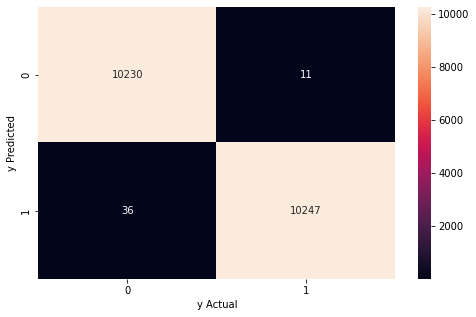

In [57]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test_bal_without_res, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Actual')
plt.ylabel('y Predicted')
plt.show()

## ***CONCLUSION***

---
This study addresses the problem of class imbalance in predicting hotel cancellations. I have used the SMOTE oversampling technique to solve this problem. This study shows that after solving this problem with SMOTE, the performance of  machine learning classifiers is significantly improved. All classifier models show significant improvements over the unbalanced and balanced data. Among them, Adaptive boosting along wth SMOTE, which produces a score as high as 99.77% in all performance metrics included in this study. The proposed method can solve the problem of unbalanced data sets, and predictive models can allow hotel managers to calculate their losses based on various senarios.

The prediction model can be implemented to the hotels booking system to help with the process, as the most significant factors in the Adaptive boosting model is Reservation status a categorical variable represents  booking status.

A cancellation model could allow hotel owners to implement less permissive tactics without amplifying their vulnerabilities. This could lead to more offers, as a more flexible booking strategy creates more customers.
In addition, these classifiers allow hotel management to predict and prepare for possible reservation cancellations. Additionally, the hospitality industry can benefit from this kind of approach to increase revenue by improving classifier performance through more accurate demand forecasting

The study conducted has some constraints. Firstly, the majority of the dataset features describe customers. The current system is acceptable, despite the fact that guests actions frequently reveal details about the hotels they have reserved.
However, the forecast can be more accurate by including more hotel-specific details in the algorithm. Additionally, the dataset only includes data on reservations made between July 1, 2015, and August 31, 2017, which is not the most recent data. 



---

